## Importing packages

In [1]:
import os, sys
import numpy as np
import pandas as pd
import pickle as pkl
%matplotlib inline
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.dirname(os.path.abspath('..')))
from mass_automation.sample_identification.plot import plot_pca

## PCA (Principal Component Analysis)

allows to reduce dimensionality of spectra vectors (check *mass_spectra_vectorization* notebook to learn what is it) and analyze similarity of spectra.

First, let's load spectra vectors dataset, which we made in *mass_spectra_vectorization* notebook

<b>!! Pickle file with tea spectra vectors is located in */data/pca_plot_files/spec_vecs_dictionary.pkl*. You can change path to pickle, but specify it in the cell below. If you want to use spectra vectors dictionary, which you did in
    *mass_spectra_vectorizetion* notebook, specify the path to this file yourself!!</b>

In [2]:
spec_path = os.path.join(os.path.dirname(os.path.abspath('..')), 'data', 'plot_pca_files', 'spec_vecs_dictionary.pkl')

In [3]:
with open(spec_path, 'rb') as f:
    spec_vecs = pkl.load(f)

It is convenient to work with csv to fill out information about samples

<b>!! table with tea samples is located in */data/pca_tables/Tea_table.csv*. You can change path to table, but specify it in the cell below !!</b>

In [4]:
table_path = os.path.join(os.path.dirname(os.path.abspath('..')), 'data', 'pca_tables', 'Tea_table.csv')

In [5]:
df = pd.read_csv(table_path, encoding='Windows-1251', sep=';')
df.head(5)

,Vector_name,Type,Lemon,Berries,Bergamot,Mint,Chamomile
0,Tea_1_18_01_128.mzXML,Black,no,no,no,no,no
1,Tea_1_18_01_129.mzXML,Black,no,no,no,no,no
2,Tea_1_18_01_130.mzXML,Black,no,no,no,no,no
3,Tea_2_19_01_131.mzXML,Massala,no,no,no,no,no
4,Tea_2_19_01_132.mzXML,Massala,no,no,no,no,no


With *plot_pca* function we can visualize PCA maps. We need only create function arguments out of Pandas Dataframe

In [6]:
# This dictionary helps to color points on PCA maps based on specific characteristic, encoded with class_decoder
# In this example, classes are tea types
colormapper = {
    'Chamomile': 'red',
    'Green': 'green',
    'Oolong': 'blue',
    'Black': 'orange',
    'Massala': 'yellow',
    'Pu-erh': 'purple'
}

In [7]:
# This function helps to get sample number out of filename.
#(Be careful, this function works only with filenames in this dataset)
def take_code(filename):
    """Returns tea code by mzXML filename. 
    """
    code = filename.split('_')[1]
    return code

In [8]:
class_decoder = df['Type']   # Pandas Series with tea types
name_decoder = np.array([take_code(i) for i in df['Vector_name'].astype(str)])  # Numpy array with sample names decoder
required_keys = df['Vector_name'].astype(str)   # Keys in Python dictionary, you want to visualize

### !! Function arguments must be created in the same order of listing decoders !!

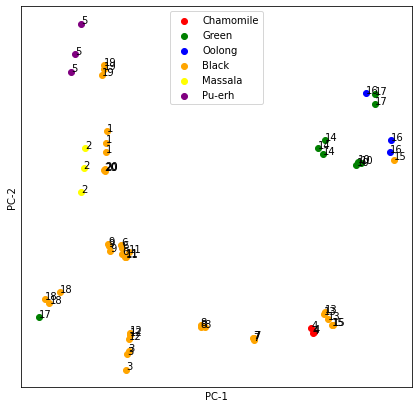

In [9]:
plot_pca(spec_vecs,
         required_keys,
         class_decoder,
         name_decoder,
         colormapper,
         dim_red="PCA",   # Dimension reduction algorithm. 'TSNE' is also available
         figsize=(7, 7),
         IsNameDecoder=True,  # If True, show name_decoder (in this case, tea sample numbers)
         show=True)

## PCA map on masses

Let's take a closer look at the spectra vectors

(400.0, 450.0)

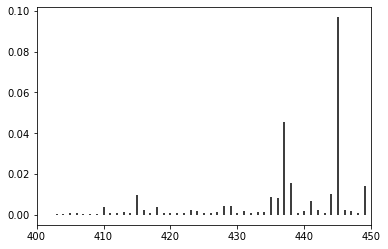

In [10]:
plt.vlines(np.arange(400, 450), 0, spec_vecs['Tea_1_18_01_128.mzXML'])
plt.xlim(400, 450)

If vectorization method was maximal intensity and each bin was equal to 1 Da, then we can interpritate vector component as maximal intensity in mass interval. 

So, if we have a big dataset of mass spectra, the information above helps find correlations between maximal intensities in different mass intervals.

How does it work?

Before, we had objects in datasets as samples with features (maximal intensities in mass intervals). But if we make mass intervals as objects and maximal intensities in the interval in different samples as features, we can show how maximal intensity in each bin changes with the change of sample. 

Let's see an example

In [11]:
X = np.zeros((len(spec_vecs.keys()), len(spec_vecs['Tea_14_31_01_167.mzXML'])))  # Create data matrix from spectra vectors dictionary
for i, key in enumerate(spec_vecs.keys()):
    X[i] = spec_vecs[key]
    
X = X.T   # Transpose the data matrix
X = X[3:] # Nevermind, it is just filtering zeros in specta vectors

mass_vecs = {}   # Create mass intervals vector dictionary
for i in range(847):
    mass_vecs[153+i] = X[i]  # 153 is because first mass interval in X is for 153-154 m/z

Now we can use PCA on these vectors

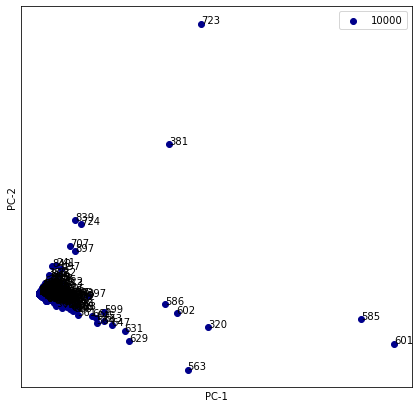

In [12]:
plot_pca(mass_vecs,
         required_keys=list(mass_vecs.keys()),
         name_decoder=list(mass_vecs.keys()),
         class_decoder=np.zeros(847)+10000, colormapper={10000: 'darkblue'},
         min_bin=0,
         max_bin=60,
         IsNameDecoder=True,
         figsize=(7, 7))

What we see in this map? 
1. Big cluster of low intense non informational peaks.
2. Close pairs of (586, 602) and (585, 601)

Let's look on how intensities are distributed in each sample:

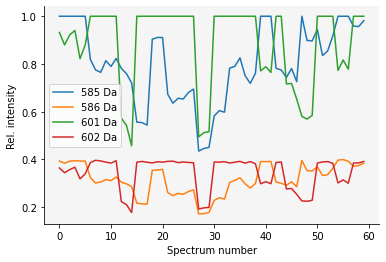

In [13]:
fig, ax = plt.subplots(figsize=(6, 4), frameon=False)
ax.patch.set_facecolor('whitesmoke')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(mass_vecs[585], label='585 Da')
plt.plot(mass_vecs[586], label='586 Da')
plt.plot(mass_vecs[601], label='601 Da')
plt.plot(mass_vecs[602], label='602 Da')
plt.xlabel('Spectrum number')
plt.ylabel('Rel. intensity')
plt.legend()

We see that 585 and 586 are just isotopologue peaks from one isotopic distrubution. So do 601 and 602. We see correlations between these two isotopic distributions.